In [8]:
from IPython.display import Video, HTML, Image, SVG
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import gzip
import pickle
import matplotlib
import matplotlib.pyplot as plt
from celluloid import Camera

##### Machine Learning and Applications - Decision Trees and Ensembling Methods

### David Picard 
### École des Ponts ParisTech
### david.picard@enpc.fr

# Region based classification


![region](region.png)


1. Memorizing all regions is cumbersome
    + R 1 = {(a 1 , b 1 , c 1 , d 1 ), y 1 }
    + R 2 = {(a 2 , b 2 , c 2 , d 2 ), y 2 }
    + ...



2. Classification requires to check all regions

```python
  for region Ri in all regions:
    if x ∈ Ri:
      return yi
```

## Tree based equivalent


![tree1](tree1.png)

![tree2](tree2.png)

![tree3](tree3.png)

## Tree representation

![dt](dt.png)

## Decision Tree

A decision tree is a hierarchical classifier with a tree structure where each node partitions the feature space along a specified component.

Leo Breiman (1928 - 2005)

![leo](leo.jpg)

## Growing the tree

1. Tree($\mathcal{S} = \{\mathbf{x}_i, y_i\}$):
2. $\quad$if $\vert\mathcal{S}\vert < T$:
3. $\quad\quad$return $\text{Leaf}(\text{argmax}_c\sum_i 1_{y_i=c}$)
4. $\quad d^\star, \theta^\star = \text{argmax}_{d,\theta} \text{Gain}(\mathcal{S}, d, \theta)$
5. $\quad T_1 = \text{Tree}(\{\mathbf{x}_i, y_i\}\in\mathcal{S} \vert \mathbf{x}_i[d^\star] < \theta^\star)$
6. $\quad T_2 = \text{Tree}(\{\mathbf{x}_i, y_i\}\in\mathcal{S} \vert \mathbf{x}_i[d^\star] \geq \theta^\star)$
7. $\quad$return $\text{Node}(d^\star, \theta^\star, T_1, T_2)$

## Gain measure

Proportion of class $k$ in $\mathcal{S}$

$$ p_k(\mathcal{S}) = \frac{1}{\vert\mathcal{S}\vert} \sum_{y_i = k} 1 $$

Prediction for $\mathcal{S}$

$$f(\mathcal{S}) = \text{argmax}_k p_k(\mathcal{S}) $$

0-1 loss

$$C(\mathcal{S}) = \frac{1}{N}\sum_i (1 - \delta(y_i, f(\mathbf{x}_i)) = 1 - p_{f(\mathcal{S})}(\mathcal{S})$$

How much did the error decrease with the split on component $d$ at threshold $\theta$ that leads to subsets $\mathcal{S}_1$ and $\mathcal{S}_2$:

$$ \text{Gain}(\mathcal{S}, d, \theta) = C(\mathcal{S}) - \left[ \frac{N_1}{N}C(\mathcal{S}_1) + \frac{N_2}{N}C(\mathcal{S}_2) \right] $$

Choose $d, \theta$ with maximal gain

## Information Gain

Other popular gain measures:

- Entropy

$$C(\mathcal{S}) = -\sum_k p_k(\mathcal{S})\log p_k(\mathcal{S}) $$

- Gini index

$$C(\mathcal{S}) = -\sum_k p_k(\mathcal{S})(1- p_k(\mathcal{S}))$$

## Small example

In [2]:
X = np.random.rand(75, 2)
y = 1.*(X[:,1] > X[:,0])

In [3]:
plt.scatter(X[:,0], X[:,1], c=y)

In [4]:
def entropyGain(X, y, d, theta):
    if len(y) <= 1:
        return 0.
    p = y.mean()
    e = jax.scipy.special.entr(p)
    l = 1.*(X[:,d] < theta)
    p1 = (y * l).sum()/(l.sum()+1e-12)
    e1 = jax.scipy.special.entr(p1)
    r = 1-l
    p2 = (y * r).sum()/(r.sum()+1e-12)
    e2 = jax.scipy.special.entr(p2)
    return e - (l.sum()*e1 + r.sum()*e2)/len(y)

In [5]:
def findBestTheta(X, y, d, gain=entropyGain):
    n = len(y)
    best_g = -1.
    theta = None
    xx = jnp.sort(X[:,d])-1e-7
    for t in xx:
        g = gain(X, y, d, t)
        if g > best_g:
            best_g = g
            theta = t
    if theta == None:
        print('theta faillure!!')
    return theta, best_g

In [6]:
def findBestDTheta(X, y, gain=entropyGain):
    best_d = None
    theta = None
    best_g = -1
    for d in range(X.shape[1]):
        t, g = findBestTheta(X, y, d, gain)
        if g > best_g:
            best_d = d
            theta = t
            best_g = g
    if best_d is None:
        print('D failure!!')
    return best_d, theta

In [7]:
class BinaryClassificationTree():
    def __init__(self, X, y, gain=entropyGain, min_size=1):
        p = y.mean()
        if len(y) <= min_size or jax.scipy.special.entr(p) == 0.:
            self.label = 1.*(p>=0.5)
        else:
            self.label = None
            self.d, self.theta = findBestDTheta(X, y, gain)
            ind = 1.*(X[:,self.d] < self.theta) 
            if ind.sum() == 0 or ind.sum() == len(y):
                print('single split !!! {} {} {}'.format(ind, y, X))
            ind1 = ind.nonzero()
            X1 = X[ind1]
            y1 = y[ind1]
            ind2 = (1-ind).nonzero()
            X2 = X[ind2]
            y2 = y[ind2]
            self.T1 = BinaryClassificationTree(X1, y1, gain=gain, min_size=min_size)
            self.T2 = BinaryClassificationTree(X2, y2, gain=gain, min_size=min_size)
    def __call__(self, X):
        if self.label is not None:
            return self.label * jnp.ones(len(X))
        return jnp.concatenate([ self.T1([x]) if x[self.d] < self.theta else self.T2([x]) for x in X])

In [8]:
T = BinaryClassificationTree(X, y)

In [9]:
t = 50; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

## Decision Trees


- Interpretable

- Fast

- Handle categorical data





But

- Poor accuracy

- Unstable

- Need a lot of examples

- Finding the optimal tree is hard, growing is greedy



## Unstable

In [17]:
y[6] = 1 - y[6]
T = BinaryClassificationTree(X, y)

In [18]:
t = 50; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

## Generalization

Theorem: For a tree of $n$ nodes in dimension $d$ and for $m$ samples, we have with
probability $\delta$

$$ R \leq R_e + \sqrt{\frac{(n+1)\log_2(d+3) + \log_2(2/\delta)}{2m}}$$



Exercise: What is the VC dimension of decision tree
over $\{0, 1\}^d$ ?

# Random Forest

Overcome DT instabilities by averaging $B$ randomized trees

- Randomized training set $\mathcal{A}_b \subset \mathcal{A}$
- Randomized components $\mathcal{x} \in \mathcal{X}_b \subset \mathcal{X}$

Final decision by majority vote: $f(\mathbf{x}) = \text{argmax}_d \left[\sum_b f_b(\mathcal{x})\right]_d$

- Average value for regression

## Limiting overfitting

Ensemble of classifier $h_1, \dots, h_K$, define margin function

$$ mg(\mathbf{x}, y) = \text{avg}_k \mathbb{1}[h_k(\mathbf{x}) = y] - \max_{j\neq y}\text{avg}_k \mathbb{1}[h_k(\mathbf{x}) = j] $$
(difference between true class vote and max false class vote)

Generalization error 

$$ R = \mathbb{P}[ mg(\mathbf{x}, y) < 0 ] $$



Random forest: classifier drawn i.i.d. from a distribution of parameters $\Theta$

Theorem (Breiman): As the number of trees increases, for almost surely all sequences $\Theta_1, \dots$, the generalization error $R$ converges to

$$ \mathbb{P} \left[ \mathbb{P}_\Theta[ h_\theta(\mathbf{x}) = y ] - \max_{j\neq y}\mathbb{P}_\Theta[h_\theta(\mathbf{x}) = j] < 0\right] $$ 


R does not increase as the number of trees grows, limiting overfitting

In [38]:
class RandomForest():
    def __init__(self, X, y, nb_tree=25, p=0.5):
        self.trees = []
        n = len(y)
        k = int(p*n)
        for b in range(nb_tree):
            i = np.random.permutation(n)
            Xb = X[i[0:k], ...]
            yb = y[i[0:k]]
            DT = BinaryClassificationTree(Xb, yb)
            self.trees.append(DT)
    def __call__(self, X):
        y = []
        for DT in self.trees:
            y.append(DT(X))
        return 1.*(jnp.array(y).mean(axis=0))

In [39]:
T = RandomForest(X, y)

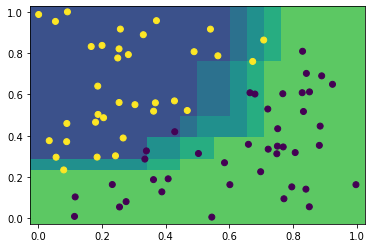

In [41]:
t = 20; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

In [42]:
t = 20; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -1.*(y_pred>0.5), shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

In [43]:
T = RandomForest(X, y, nb_tree=100, p=0.2)

In [44]:
t = 50; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

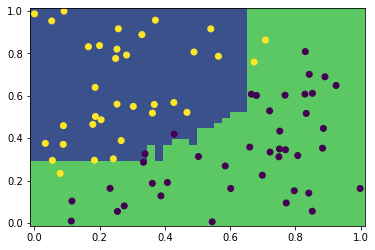

In [48]:
t = 50; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -1.*(y_pred>0.5), shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

## Reducing the variance

What is the variance of the average of $B$ random variables, each of variance $\sigma^2$, that are correlated by $\rho$?

Correlation

$$\frac{1}{\sigma^2}\mathbb{E}\left[ (x_i - \mu)(x_j - \mu) \right] = \rho \geq 0 $$

\begin{align*}
	\mathbb{E}[x_i^2] = \sigma^2 +m^2\\
	\mathbb{E}[x_ix_j] = \rho \sigma^2 +m^2
\end{align*}

$$ Var\left(\frac{\sum_i x_i}{B}\right) = \frac{1}{B^2}Var\left(\sum_i x_i \right)$$

$$ = \frac{1}{B^2} \left( \mathbb{E}\left[ \left(\sum_ix_i \right)^2 \right] - \mathbb{E}\left[\sum_ix_i \right]^2\right)$$

$$=\frac{1}{B^2} \left( \sum_{i,j} \mathbb{E}\left[ x_i x_j \right] - \left( \sum_i \mathbb{E}\left[ x_i \right] \right)^2 \right)$$

$$=\frac{1}{B^2} \left(B(\sigma^2+m^2) + (B^2-B)(\rho\sigma^2 + m^2)  - B^2m^2 \right) $$

$$Var\left(\frac{\sum_i x_i}{B}\right) = \frac{1}{B^2} \left(B(\sigma^2+m^2) + (B^2-B)(\rho\sigma^2 + m^2)  - B^2m^2 \right)$$

$$=\frac{\sigma^2 + m^2}{B} + \rho\sigma^2 + m^2 - \frac{\rho\sigma^2 + m^2}{B} - m^2$$

$$=\frac{\sigma^2}{B} + \rho\sigma^2 - \frac{\rho\sigma^2}{B}$$

$$= \rho\sigma^2 + \frac{1-\rho}{B}\sigma^2$$

$$\leq \sigma^2 \text{ iff } \rho< 1 \text{ and } B > 1$$

# Ensemble learning


ERM principle subject to bias-variance trade-off


- Simple model: low estimation error, large approximation error


- Complex model: high estimation error, low approximation error





Ensemble idea: aggregate many simple models

- Each model has low estimation error

- Aggregation has low approximation error



## Bagging


Assume $M$ __independent__ predictors $h_m(\mathbf{x})$

- Trained on different features (_e.g._, colors and textures)

- Trained on different samples (_e.g._, different images)




Bagging aggregate
\begin{align*}
	h(\mathbf{x}) = \sum_m h_m(\mathbf{x})
\end{align*}
Corresponds to a voting strategy

## Exemple

Random axis, select optimal threshold

In [103]:
class RandomAxisClassifier():
    def __init__(self, X, y, d):
        self.d = d
        self.theta, _ = findBestTheta(X, y, d)
        i = jnp.where(X[:,d]<self.theta)
        self.y = (y[i].mean()>0.5)
    def __call__(self, X):
        return (X[:,self.d]<self.theta) if self.y else 1-(X[:,self.d]<self.theta)

In [104]:
class BaggingClassifier():
    def __init__(self, X, y, nb_cls, p=0.5):
        self.cls = []
        n = len(y)
        k = int(p*n)
        for b in range(nb_cls):
            i = np.random.permutation(n)
            Xb = X[i[0:k], ...]
            yb = y[i[0:k]]
            self.cls.append(RandomAxisClassifier(Xb, yb, np.random.randint(2)))
    def __call__(self, X):
        y = []
        for c in self.cls:
            y.append(c(X))
        return jnp.array(y).mean(axis=0)

In [105]:
T = BaggingClassifier(X, y, 1)

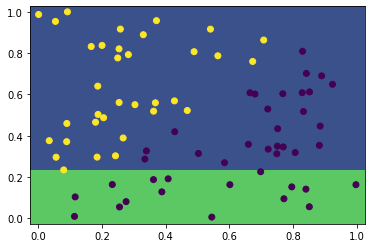

In [106]:
t = 20; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

In [107]:
T = BaggingClassifier(X, y, 10)

In [108]:
t = 20; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

In [113]:
T = BaggingClassifier(X, y, 100, p=0.2)

In [114]:
t = 20; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

# Boosting


In bagging, each predictor as the same weight

- Some decisions are redundant

- Some decisions are bad and we know they are bad


Can we define weights that better reflect each classifier strong points?



## Adaboost

Key ideas:

- Weight each sample $\mathbf{x}_i$ with $w_i$
- Train a classifier $g$ with weighted error $w_i I(y_i \neq g(\mathbf{x}_i))$
- Update weights such that samples with high error have higher weights
- Train new classifier $f_m$ with updated weighted error
- Combine both classifier $g \leftarrow g + \beta f_m$
- Iterate until combined classifier is good enough


## Exponential loss function
\begin{align*}
	L(y, f(\mathbf{x})) = e^{-yf(x)}
\end{align*}
Given a classifier $f_{m-1}$, we want to add a new classifier that reduces the error

We have to solve
\begin{align*}
	\beta_m, G_m = \arg\min_{\beta, G} \sum_i\exp[-y_i (f_{m-1}(\mathbf{x}_i) + \beta G(\mathbf{x}_i))]
\end{align*}

## Independent updates

\begin{align*}
	\beta_m, G_m = \arg\min_{\beta, G} \sum_i\exp[-y_i (f_{m-1}(\mathbf{x}_i) + \beta G(\mathbf{x}_i))]
\end{align*}
Can be rewritten as
\begin{align*}
	\beta_m, G_m = \arg\min_{\beta, G} \sum_i w_i\exp[-y_i \beta G(\mathbf{x}_i)]
\end{align*}
with 
\begin{align*}
	w_i = \exp[-y_i f_{m-1}(\mathbf{x}_i)]
\end{align*}

## Solving for $G$
Remark that given $\beta > 0$
\begin{align*}
	\arg\min_G\sum_i w_i\exp[-y_i \beta G(\mathbf{x}_i)]
\end{align*}
is obtained by
\begin{align*}
	\arg\min_G \sum_i w_i I(y_i \neq G(\mathbf{x}_i))
\end{align*}
because
\begin{align*}
	\sum_i w_i\exp[-y_i \beta G(\mathbf{x}_i)] =  e^{-\beta} \sum_{y_i = G(\mathbf{x}_i)} w_i  + e^{\beta} \sum_{y_i \neq G(\mathbf{x}_i)} w_i  
\end{align*}

## Solving for $\beta$
Given $G$, we have to solve
\begin{align*}
	\arg\min_\beta\sum_i w_i\exp[-y_i \beta G(\mathbf{x}_i)]
\end{align*}
Remark that
\begin{align*}
	\sum_i w_i\exp[-y_i \beta G(\mathbf{x}_i)]&\\
	\quad\quad = \left(e^\beta - e^{-\beta} \right)&\sum_iw_i I(y_i \neq G(\mathbf{x}_i) + e^{-\beta}\sum_i w_i
\end{align*}
Thus
\begin{align*}
	\beta = \frac{1}{2} \log \frac{1 - err_m}{err_m},\quad err_m = \frac{\sum_i w_i I(y_i \neq G(\mathbf{x}_i)}{\sum_i w_i}
\end{align*}

## Adaboost

1. Initialize $\forall i, w_i = 1/N$
2. For $m = 1 \ldots M$
3. $\quad$Fit classifier $G_m(\mathbf{x})$ to training sample using $w_i$
4. $\quad$ Compute \begin{align*}
			err_m = \frac{\sum_i w_i I(y_i \neq G_m(\mathbf{x}_i))}{\sum_i w_i}
		\end{align*}
5. $\quad$ Compute $\beta_m = \log ((1-err_m)/err_m)$
6. $\quad$ Set $\forall i, w_i \leftarrow w_i e^{\beta_m I(y_i \neq G_m(\mathbf{x}_i))}$
7. Output $G(\mathbf{x}) = \sum_m \beta_m G_m(\mathbf{x})$

In [226]:
def weightedError(w, y_pred, y_true):
    return (w * (y_pred != y_true)).sum()/w.sum()

In [227]:
def weightedFindBestTheta(w, X, y, d):
    n = len(y)
    err = w.sum()+1
    theta = None
    p = None
    xx = jnp.sort(X[:,d])-1e-7
    for t in xx:
        e = weightedError(w, 1.*(X[:,d] < t), y)
        if e < err:
            err = e
            theta = t
            p = True
        e = weightedError(w, 1. - (X[:,d] < t), y)
        if e < err:
            err = e
            theta = t
            p = False
    if theta == None:
        print('theta faillure!!')
    return theta, p, err

In [228]:
class WeightedRandomAxisClassifier():
    def __init__(self, w, X, y, d):
        self.d = d
        self.theta, self.y, self.err = weightedFindBestTheta(w, X, y, d)
    def __call__(self, X):
        return 1.*(X[:,self.d]<self.theta) if self.y else 1.-(X[:,self.d]<self.theta)

In [236]:
class AdaBoost():
    def __init__(self, X, y, nb_cls=5):
        n = len(y)
        w = jnp.ones(n)/n
        self.beta = []
        self.cls = []
        for b in range(nb_cls):
            err_b = []
            cls_b = []
            for d in range(X.shape[1]):
                c = WeightedRandomAxisClassifier(w, X, y, d)
                cls_b.append(c)
                err_b.append(c.err)
            a = jnp.argmin(jnp.array(err_b))
            c = cls_b[a]
            e = c.err
            b = jnp.log((1-e)/e)
            w = w * jnp.exp(b * (c(X)!=y))
            self.beta.append(b)
            self.cls.append(c)
    def __call__(self, X):
        y = []
        for i, c in enumerate(self.cls):
            y.append(self.beta[i] * c(X))
        return jnp.array(y).mean(axis=0)            

In [239]:
T = AdaBoost(X, y, 2)

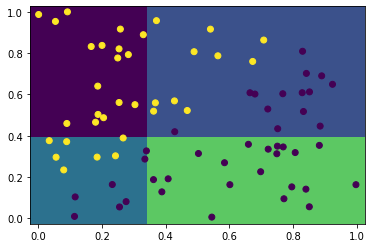

In [240]:
t = 20; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

In [241]:
T = AdaBoost(X, y, 10)

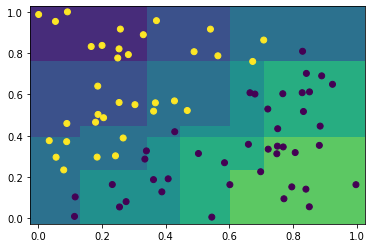

In [242]:
t = 20; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

In [243]:
T = AdaBoost(X, y, 50)

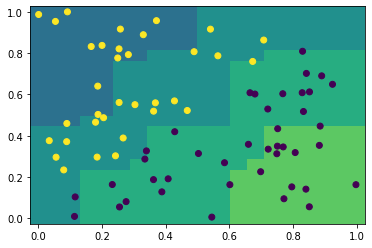

In [244]:
t = 20; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(T(xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(X[:,0], X[:,1], c=y)

## Remarks


Classifiers have to be weak

- A perfect classifier yields $\beta_m = \infty$ breaking subsequent classifiers

- Example: Kernel SVM with sufficiently tight Gaussian kernel


Classifiers have to be slightly better than random

- Worst than random gets an negative weight (opposite classifier)

- Example: single feature classifier





Boosted Decision Trees are an excellent first try in most cases



## Exercise

Show that 
\begin{align*}
	f^\star(\mathbf{x}) &= \arg\min_f \mathbb{E}_{\sim(\mathbf{x},y)}\left[ e^{-yf(\mathbf{x})} \right]= \frac{1}{2}\log\frac{P[y = 1 | \mathbf{x}]}{P[y=-1|\mathbf{x}]}
\end{align*}

\begin{align*}
	\frac{\partial \mathbb{E}_{\sim(\mathbf{x},y)}\left[ e^{-yf(\mathbf{x})} \right]}{\partial f} &= 	\mathbb{E}_{\sim(\mathbf{x},y)}\left[ -y e^{-yf(\mathbf{x})} \right] = 0\\
	\mathbb{E}\left[ -ye^{-yf(\mathbf{x})} \right] = -e^{-f(\mathbf{x})}&P[y=1|\mathbf{x}] + e^{f(\mathbf{x})}P[y=-1|\mathbf{x}]\\
	e^{2f(\mathbf{x})} &= \frac{P[y=1|\mathbf{x}]}{P[y=-1|\mathbf{x}]}
\end{align*}

# Decision Trees and Ensemble Learning, take home

Decision Trees

- Simple

- Fast

- Explainable (domain experts understand the decision process)

- Handle categorical data (or even mixed)




But


- Overfit, unstable

- Require massive amount of data



Random forest

- Simple, Fast, handle categorical data

- Stable

- No longer explainable




Ensemble

- Bagging: simple solution, good idea to reduce bias

- Boosting: optimized combination




Large literature and many libraries on boosting

- Bossted trees: very good default classifier in many cases

Grinsztajn, Leo, Edouard Oyallon, and Gael Varoquaux. "Why do tree-based models still outperform deep learning on typical tabular data?." Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track. 2022.

